## 1. Get the vehicle images and non-vehicle images

In [1]:
# Import
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split #0.18.2
from sklearn.grid_search import RandomizedSearchCV
from scipy.ndimage.measurements import label
from collections import deque
%matplotlib inline

/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Get the car images and not car images
# HERE, add some not cars images corped from video and for balance, copped some car images.
car_images = glob.glob('./vehicles/**/*.png')
notcar_images = glob.glob('./non-vehicles/**/*.png')
# notcar_images = glob.glob('./non-vehicles/error_samples/*.png')
# notcar_images.extend(glob.glob('./non-vehicles/Extras/*.png'))
# notcar_images.extend(glob.glob('./non-vehicles/error_samples/*.png'))
# notcar_images.extend(glob.glob('./non-vehicles/error_samples/*.png'))
# notcar_images.extend(glob.glob('./non-vehicles/error_samples/*.png'))
n_samples = min(len(car_images),len(notcar_images))
print("The samples minimum is: ", n_samples)
print(len(car_images), len(notcar_images))

The samples minimum is:  8792
8792 9129


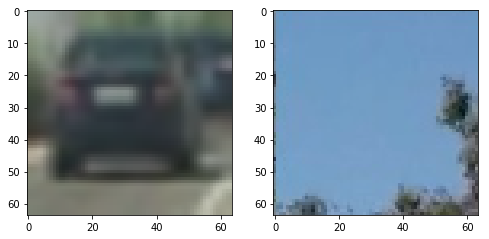

In [3]:
# Show some images 
comp_fig, (ax1, ax2) = plt.subplots(1,2, figsize = (7,4))
comp_fig.tight_layout()
car_0 = mpimg.imread(car_images[0])
#print(car_0.shape)
ax1.imshow(car_0)
notcar_0 = mpimg.imread(notcar_images[0])
ax2.imshow(notcar_0)

## 2. Extract features

### 2.1 Compute color histogram

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### 2.2 Compute spatial features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

### 2.3 Compute HOG features

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

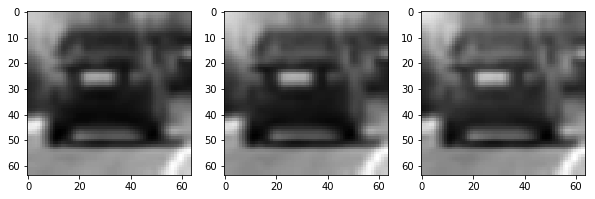

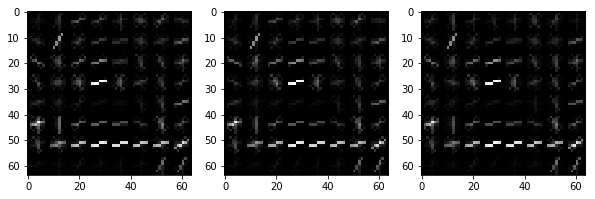

In [7]:
# Show hog image every channel
hog_fig, (ax11, ax12, ax13) = plt.subplots(1,3, figsize = (10, 7))
hog_fig, (ax21, ax22, ax23) = plt.subplots(1,3, figsize = (10, 7))

car_0_ch1 = car_0[:,:,0]
car_0_ch1_feat, car_0_ch1_hog = get_hog_features(car_0_ch1, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax11.imshow(car_0_ch1,cmap='gray')
ax21.imshow(car_0_ch1_hog,cmap='gray')
plt.imsave('./output_images/car_0_ch1.jpg',car_0_ch1)
plt.imsave('./output_images/car_0_ch1_hog.jpg',car_0_ch1_hog)

car_0_ch2 = car_0[:,:,1]
car_0_ch2_feat, car_0_ch2_hog = get_hog_features(car_0_ch2, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax12.imshow(car_0_ch2,cmap='gray')
ax22.imshow(car_0_ch2_hog,cmap='gray')
plt.imsave('./output_images/car_0_ch2.jpg',car_0_ch2)
plt.imsave('./output_images/car_0_ch2_hog.jpg',car_0_ch2_hog)

car_0_ch3 = car_0[:,:,2]
car_0_ch3_feat, car_0_ch3_hog = get_hog_features(car_0_ch3, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax13.imshow(car_0_ch3,cmap='gray')
ax23.imshow(car_0_ch3_hog,cmap='gray')
plt.imsave('./output_images/car_0_ch3.jpg',car_0_ch3)
plt.imsave('./output_images/car_0_ch3_hog.jpg',car_0_ch3_hog)

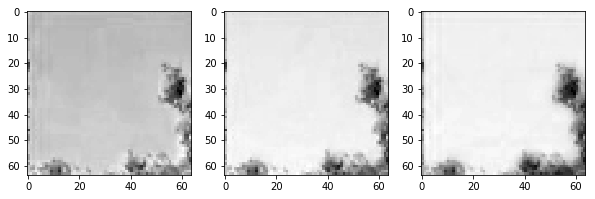

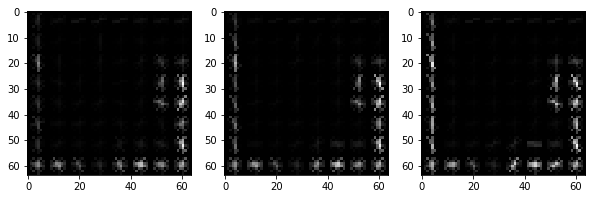

In [8]:
# Show hog image every channel
hog_fig, (ax11, ax12, ax13) = plt.subplots(1,3, figsize = (10, 7))
hog_fig, (ax21, ax22, ax23) = plt.subplots(1,3, figsize = (10, 7))

notcar_0_ch1 = notcar_0[:,:,0]
notcar_0_ch1_feat, notcar_0_ch1_hog = get_hog_features(notcar_0_ch1, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax11.imshow(notcar_0_ch1,cmap='gray')
ax21.imshow(notcar_0_ch1_hog,cmap='gray')
plt.imsave('./output_images/notcar_0_ch1.jpg',notcar_0_ch1)
plt.imsave('./output_images/notcar_0_ch1_hog.jpg',notcar_0_ch1_hog)

notcar_0_ch2 = notcar_0[:,:,1]
notcar_0_ch2_feat, notcar_0_ch2_hog = get_hog_features(notcar_0_ch2, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax12.imshow(notcar_0_ch2,cmap='gray')
ax22.imshow(notcar_0_ch2_hog,cmap='gray')
plt.imsave('./output_images/notcar_0_ch2.jpg',notcar_0_ch2)
plt.imsave('./output_images/notcar_0_ch2_hog.jpg',notcar_0_ch2_hog)

notcar_0_ch3 = notcar_0[:,:,2]
notcar_0_ch3_feat, notcar_0_ch3_hog = get_hog_features(notcar_0_ch3, orient=9, pix_per_cell= 8, cell_per_block= 2, vis= True, feature_vec= True)
ax13.imshow(notcar_0_ch3,cmap='gray')
ax23.imshow(notcar_0_ch3_hog,cmap='gray')
plt.imsave('./output_images/notcar_0_ch3.jpg',notcar_0_ch3)
plt.imsave('./output_images/notcar_0_ch3_hog.jpg',notcar_0_ch3_hog)

### 2.4 Extract features

In [9]:
def extract_features(imgs, color_space='YCrCb', 
                     spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel= 'ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 3. Training

In [10]:
car_features = []
notcar_features = []

In [11]:
# Parameters
g_color_space = 'YCrCb'#'YUV'
g_spatial_size = (32,32)
g_hist_bins = 32
g_orient = 9
g_pix_per_cell = 8
g_cell_per_block = 2
g_hog_channel = 'ALL'
g_spatial_feat = True
g_hist_feat = True
g_hog_feat = True

In [12]:
# Get the car features
car_features = extract_features(car_images, color_space=g_color_space, 
                        spatial_size=g_spatial_size, hist_bins=g_hist_bins, 
                        orient=g_orient, pix_per_cell=g_pix_per_cell, 
                        cell_per_block=g_cell_per_block, 
                        hog_channel=g_hog_channel, spatial_feat=g_spatial_feat, 
                        hist_feat=g_hist_feat, hog_feat=g_hog_feat)

In [13]:
# Get the not car features
notcar_features = extract_features(notcar_images, color_space=g_color_space, 
                        spatial_size=g_spatial_size, hist_bins=g_hist_bins, 
                        orient=g_orient, pix_per_cell=g_pix_per_cell, 
                        cell_per_block=g_cell_per_block, 
                        hog_channel=g_hog_channel, spatial_feat=g_spatial_feat, 
                        hist_feat=g_hist_feat, hog_feat=g_hog_feat)

In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',g_orient,'orientations',g_pix_per_cell,
    'pixels per cell and', g_cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
g_svc = LinearSVC()
# para_C = {'C':[0.10,0.40,0.70,1.00,1.20]}
# iter_para = 5
# g_svc = RandomizedSearchCV(g_svc, param_distributions= para_C, n_iter= iter_para)
# Check the training time for the SVC
t=time.time()
g_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(g_svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
30.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9877


## 4. Find cars

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [16]:
def find_cars(img, ystart, ystop, scale, svc, _X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    x_offset = 0
    img_tosearch = img[ystart:ystop,x_offset:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')#conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
       
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
#     print("ch1 shape is:", ch1.shape,
#           "\nnxblocks:", nxblocks, "\nnyblocks:",nyblocks, "\nnfeat_per_block:  ",nfeat_per_block,
#           "\nnblocks_per_window:",nblocks_per_window,"\nnxsteps:", nxsteps,"\nnysteps:", nysteps,"\n\n\n")
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     print(hog1.shape)
    
    bboxes_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
#             Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
#             print("\n--ypos:",ypos,
#                   "\n--yend:",(ypos + nblocks_per_window),
#                   "\n--xpos:",xpos,
#                   "\n--xend:",(xpos + nblocks_per_window),
#                   "\n--xleft:",xleft,"\n--ytop:",ytop)

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
#             # Get Hog features
            hog_feat1 = get_hog_features(subimg[:,:,0],orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
            hog_feat2 = get_hog_features(subimg[:,:,1],orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
            hog_feat3 = get_hog_features(subimg[:,:,2],orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Scale features and make a prediction
            test_features = _X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            multi_color = (np.random.randint(0, 255),np.random.randint(0, 255),np.random.randint(0,255))
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + x_offset
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),multi_color,7)#(0,0,255),6) 
                bboxes_list.append(((int(xbox_left), int(ytop_draw+ystart)),
                                    (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, bboxes_list

In [100]:
# Parameters
g_y_start = 400
g_y_stop = 656
g_scale = 1.0

In [101]:
# Test find cars
test_1_image = plt.imread('./test_images/test1.jpg')
test_1_draw_image, _= find_cars(test_1_image, ystart = g_y_start, ystop = g_y_stop, 
                            scale = g_scale, svc = g_svc, _X_scaler = X_scaler, orient = g_orient, 
                            pix_per_cell = g_pix_per_cell, 
                            cell_per_block = g_cell_per_block, 
                            spatial_size = g_spatial_size, 
                            hist_bins = g_hist_bins)
# Test find cars
test_2_image = plt.imread('./test_images/test2.jpg')
test_2_draw_image,_ = find_cars(test_2_image, ystart = g_y_start, ystop = g_y_stop, 
                            scale = g_scale, svc = g_svc, _X_scaler = X_scaler, orient = g_orient, 
                            pix_per_cell = g_pix_per_cell, 
                            cell_per_block = g_cell_per_block, 
                            spatial_size = g_spatial_size, 
                            hist_bins = g_hist_bins)

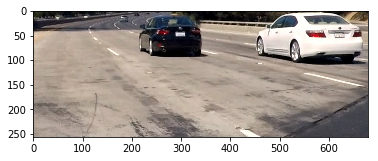

In [102]:
plt.imshow(test_1_image[g_y_start: g_y_stop,600:,:])
#print(test_1_image)

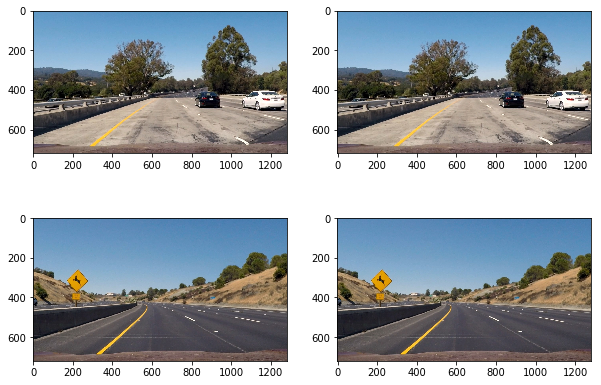

In [104]:
# Show hog image every channel
test_find_cars_fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2, figsize = (10, 7))
ax11.imshow(test_1_image)
ax12.imshow(test_1_draw_image)
ax21.imshow(test_2_image)
ax22.imshow(test_2_draw_image)
plt.imsave('./output_images/test_1_draw_boxes.jpg',test_1_draw_image)

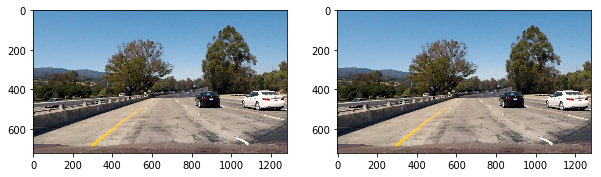

In [21]:
# Test find cars
g_y_start = 400
g_y_stop = 496
g_scale = 1.5
test_1_draw_image,_ = find_cars(test_1_image, ystart = g_y_start, ystop = g_y_stop, 
                            scale = g_scale, svc = g_svc, _X_scaler = X_scaler, orient = g_orient, 
                            pix_per_cell = g_pix_per_cell, 
                            cell_per_block = g_cell_per_block, 
                            spatial_size = g_spatial_size, 
                            hist_bins = g_hist_bins)
test_find_cars_fig, ((ax11, ax12)) = plt.subplots(1,2, figsize = (10, 7))
ax11.imshow(test_1_image)
ax12.imshow(test_1_draw_image)

In [22]:
def multi_find_cars(img, y_start_base = 400, y_stop_base = 656, scale_base = 1.0):
    _bboxes_list = []

#     for scale_mulit in range(0,14,2):
#         _scale = scale_base + scale_mulit/10
#         _, _boxes = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, X_scaler=X_scaler, orient= g_orient,
#                            pix_per_cell = g_pix_per_cell, 
#                            cell_per_block = g_cell_per_block, 
#                            spatial_size = g_spatial_size, 
#                            hist_bins = g_hist_bins)
#         _bboxes_list.extend(_boxes)
    img_region = np.copy(img)
    
    _scale = 1.0
    y_start_base = 400
    y_stop_base = 464
    _, boxes1 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
#     print(len(_bboxes_list))
#     print(len(boxes1))
    _bboxes_list.extend(boxes1)
    
    _scale = 1.0
    y_start_base = 416
    y_stop_base = 480
    _, boxes2 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
#     print(len(_bboxes_list))
#     print(len(boxes2))
    _bboxes_list.extend(boxes2)
    
    _scale = 1.5
    y_start_base = 400
    y_stop_base = 496
    _, boxes3 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
#     print(len(_bboxes_list))
#     print(len(boxes3))
    _bboxes_list.extend(boxes3)
    
    _scale = 1.5
    y_start_base = 432
    y_stop_base = 528
    _, boxes4 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
    _bboxes_list.extend(boxes4) 

    _scale = 2.0
    y_start_base = 400
    y_stop_base = 528
    _, boxes5 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
    _bboxes_list.extend(boxes5)
    
    _scale = 2.0
    y_start_base = 432
    y_stop_base = 560
    _, boxes6 = find_cars(img_region, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
    _bboxes_list.extend(boxes6)
  
    _scale = 3.5
    y_start_base = 400
    y_stop_base = 596
    _, boxes7 = find_cars(img, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
    _bboxes_list.extend(boxes7)
    
    _scale = 3.5
    y_start_base = 464
    y_stop_base = 660
    _, boxes8 = find_cars(img_region, y_start_base, y_stop_base, _scale, g_svc, _X_scaler=X_scaler, orient= g_orient,
                       pix_per_cell = g_pix_per_cell, 
                       cell_per_block = g_cell_per_block, 
                       spatial_size = g_spatial_size, 
                       hist_bins = g_hist_bins)
    _bboxes_list.extend(boxes8)
    
    return _bboxes_list

In [23]:
_test_boxes_multi = multi_find_cars(test_1_image)
#print(_test_boxes_multi)

In [24]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy      

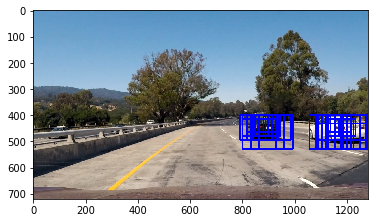

In [25]:
multi_box_img = draw_boxes(test_1_image, _test_boxes_multi)
plt.imshow(multi_box_img)
plt.imsave('./output_images/test_1_draw_multi_boxes.jpg',multi_box_img)

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [27]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [28]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rect_boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 5)
        rect_box = (np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy))
        rect_boxes.append(rect_box)
        
    # Return the image
    return img, rect_boxes

In [29]:
heat = np.zeros_like(test_1_image[:,:,0]).astype(np.float)

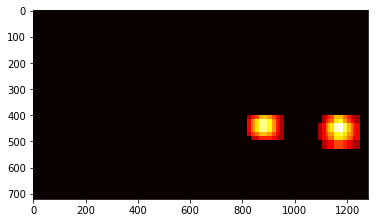

In [30]:
heat = add_heat(heat,_test_boxes_multi)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap, cmap='hot')
plt.imsave('./output_images/test_1_heatmap.jpg',heatmap)

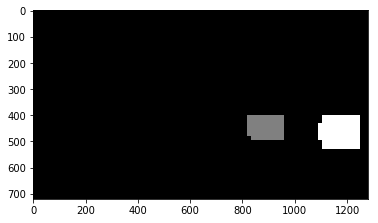

In [31]:
# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.imshow(labels[0],cmap='gray')
plt.imsave('./output_images/label.jpg', labels[0])

2


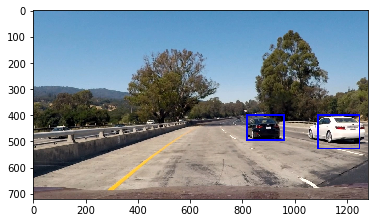

In [32]:
draw_img,test_1_rect_boxes = draw_labeled_bboxes(np.copy(test_1_image), labels)
plt.imshow(draw_img)
print(len(test_1_rect_boxes))

### 5. Apply to one image

In [113]:
frame_window_num = 10
pre_frame_heats = deque(maxlen = frame_window_num)

In [114]:
def get_box_area(startx,starty,endx,endy):
    area_len = endx - startx
    area_width = endy - starty
    area = area_len * area_width
    return area

In [128]:
def process_frame(frame_img):

    frame_boxes = []
    
    box_items = []
    
    frame_copy = np.copy(frame_img)
    frame_image_multi_boxes = multi_find_cars(frame_copy)
    
    frame_image_heat = np.zeros_like(frame_copy[:,:,0]).astype(np.float)
    frame_image_heat = add_heat(frame_image_heat,frame_image_multi_boxes)
#     frame_image_heat = apply_threshold(frame_image_heat,1)

    # Visualize the heatmap when displaying    
#     cur_heatmap = np.clip(frame_image_heat, 0, 255)
    pre_frame_heats.append(frame_image_heat)

    heatmap = np.zeros_like(frame_image_heat).astype(np.float)
    for heat in pre_frame_heats:
        heatmap = heatmap + heat
 
    heatmap = apply_threshold(heatmap,1 + 4*len(pre_frame_heats))
        
    frame_labels = label(heatmap)
    frame_draw_img, frame_boxes= draw_labeled_bboxes(np.copy(frame_img), frame_labels)
    
    
#     print("In this frame, the boxes num is", len(frame_boxes))   
#     if (len(frame_boxes) > 0):
#         print("Raw boxes are :")
#         bIsBoxValid = False
#         for box in frame_boxes:
# #             cv2.rectangle(frame_draw_img,(box[0],box[1]),(box[2],box[3]),(128,255,0), 5)
#             box_item = vehice_box()
#             box_area = get_box_area(box[0],box[1],box[2],box[3])
#             len_wid_ratio = (box[2] - box[0])/(box[3] - box[1])
#             if((box_area > 1700) and (len_wid_ratio > 0.5 and len_wid_ratio < 2.5)):
#                 box_item.count = 1
#                 box_item.min_x = box[0]
#                 box_item.min_y = box[1]
#                 box_item.max_x = box[2]
#                 box_item.max_y = box[3]
#                 box_item.area = box_area
#                 box_item.ratio = len_wid_ratio
#                 bIsBoxValid = True
#                 box_items.append(box_item)                
# #                 print("minx =%5d, miny =%5d, maxx =%5d, maxy =%5d, ratio =%2.2f,area =%7d." %(box[0],box[1],box[2],box[3], len_wid_ratio, box_area))
#                 print("minx =%5d, miny =%5d, maxx =%5d, maxy =%5d, ratio =%2.2f,area =%7d." %(box_item.min_x,box_item.min_y,box_item.max_x,box_item.max_y, box_item.ratio, box_item.area))
        
#     print(box_items)
#     for i in range(len(box_items)):
#         print(box_items[i].min_x)
#         if(bIsBoxValid):
#             box_items_Q.append(box_items)
        
#     dist = 0
#     box_items_Q_len = len(box_items_Q)
#     if(box_items_Q_len > 1):
#         for cur_box in box_items_Q[-1]:
# #             print(cur_box.min_x,cur_box.min_y,cur_box.max_x,cur_box.max_y)
#             for i in range(box_items_Q_len -1):
#                 for box_item in box_items_Q[i]:
#                     dist = np.sqrt((box_item.min_x - cur_box.min_x)**2 
#                                  + (box_item.min_y - cur_box.min_y)**2 
#                                  + (box_item.max_x - cur_box.max_x)**2 
#                                  + (box_item.max_y - cur_box.max_y)**2)
#                     print("distance %4f"%dist)
#                     if(dist < 50):
#                         cur_box.count = box_item.count + 1
#                         if(box_item.count > 5):
#                             box_item.count = 6
#                         break
                        
#     for box_item in box_items_Q[-1]:
#         if(box_item.count > 5):
#             print(box_item.min_x,box_item.min_y,box_item.max_x,box_item.max_y,box_item.count)
#             cv2.rectangle(frame_draw_img,(box_item.min_x,box_item.min_y),(box_item.max_x,box_item.max_y),(0,0,255), 5)
              
    return frame_draw_img

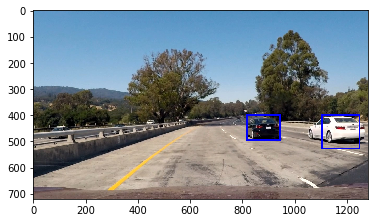

In [129]:
pre_frame_heats.clear()
# box_items_Q.clear()
test_1_frame = process_frame(test_1_image)
plt.imshow(test_1_frame)
plt.imsave('./output_images/test_1_result.jpg',test_1_frame)

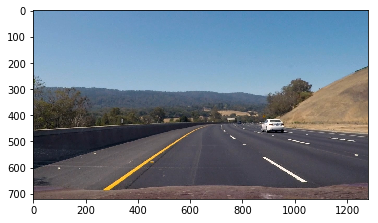

In [130]:
pre_frame_heats.clear()
test_3_image = plt.imread('./test_images/test3.jpg') 
test_3_frame = process_frame(test_3_image)
plt.imshow(test_3_frame)
# plt.imsave('./output_images/test_3_result.jpg',test_3_frame)

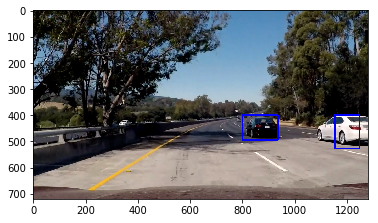

In [131]:
pre_frame_heats.clear()
test_5_image = plt.imread('./test_images/test5.jpg') 
test_5_frame = process_frame(test_5_image)
plt.imshow(test_5_frame)

## 6. Apply to video

In [70]:
pre_frame_heats.clear()

In [71]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

white_output = 'output_video/vehicle_detection.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(25,30)
clip1 = VideoFileClip("project_video.mp4").subclip(27,33)
#print(clip1)
#plt.imshow(clip1)
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/vehicle_detection.mp4
[MoviePy] Writing video output_video/vehicle_detection.mp4


 99%|█████████▉| 150/151 [08:27<00:03,  3.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/vehicle_detection.mp4 

CPU times: user 8min 3s, sys: 12.9 s, total: 8min 16s
Wall time: 8min 28s


In [ ]:
pre_frame_heats.clear()
white_output2 = 'output_video/vehicle_detection2.mp4'
clip2 = VideoFileClip("project_video.mp4").subclip(41,43)
#print(clip1)
#plt.imshow(clip1)
white_clip_2 = clip2.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip_2.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video output_video/vehicle_detection2.mp4
[MoviePy] Writing video output_video/vehicle_detection2.mp4


 43%|████▎     | 22/51 [01:19<01:44,  3.60s/it]

#### For crop image from video

In [ ]:
clip1 = VideoFileClip("project_video.mp4")
clip2 = VideoFileClip("vehicle_detection.mp4")

In [ ]:
frame_idx = 40.00

In [ ]:
frame1 = clip1.get_frame(frame_idx)
frame2 = clip2.get_frame(frame_idx)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
fig.tight_layout()
ax1.imshow(frame1)
ax2.imshow(frame2)

In [ ]:
frame_crop = frame1[420:484,170:234,:]
plt.imshow(frame_crop)
# plt.imsave("./error_samples/error169.png",frame_crop)